# Data Exploration

In [3]:
# ------------------ IMPORTS ------------------
"""
This file contains all the imports that are nessesary for this jupiter notebook.
"""
import warnings

# Suppress the libjpeg.9.dylib warning from torchvision
warnings.filterwarnings("ignore", message="Failed to load image Python extension")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt


In [ ]:
# ------------------------- Data Preparation -------------------------
"""
Data Preparation:
This step prepares the training and test datasets for the Pediatric Chest X-ray Pneumonia classification task.
We define two transformation pipelines: `train_transform` for the training set and `test_transform` for the test set.
The training set includes data augmentation to address class imbalance and improve model generalization, while the test set
only includes necessary preprocessing steps to maintain the true data distribution.

Why Augmentation Before Loading:
Data augmentation is defined before loading the dataset because PyTorch's `ImageFolder` applies transformations on-the-fly
as each image is loaded. This approach is memory-efficient, as it avoids storing multiple augmented images, and ensures
dynamic augmentation (e.g., random flips and rotations) is applied differently in each epoch, increasing the effective variety
of the training data. This is particularly important for addressing the imbalance in our dataset (more pneumonia than normal cases),
as it helps the model see varied samples of the minority class (normal) during training.

Training Transformations:
- Grayscale(num_output_channels=1): Converts the image to single-channel grayscale, as X-rays are inherently grayscale.
- Resize((128, 128)): Resizes the image to 128x128 pixels to reduce computational load and speed up training.
- RandomHorizontalFlip(p=0.5): Flips the image horizontally with a 50% probability, mimicking natural left/right symmetry in X-rays.
- RandomVerticalFlip(p=0.1): Flips the image vertically with a 10% probability, simulating rare orientation variations.
- RandomRotation(15): Rotates the image by a random angle between -15 and +15 degrees, adding variety to patient positioning.
- RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)): Applies small translations (5% shift) and scaling (5% zoom in/out)
  to simulate minor positional variations in X-ray imaging.
- ToTensor(): Converts the image to a PyTorch tensor with shape (1, H, W).
- Normalize(mean=[0.5], std=[0.5]): Normalizes the image to have a mean of 0.5 and standard deviation of 0.5, ensuring consistent input
  values for the model.

Test Transformations:
- Grayscale(num_output_channels=1): Converts the image to single-channel grayscale.
- Resize((128, 128)): Resizes the image to 128x128 pixels for consistency with the training set.
- ToTensor(): Converts the image to a PyTorch tensor.
- Normalize(mean=[0.5], std=[0.5]): Normalizes the image to match the training set’s input distribution.
No augmentation is applied to the test set to preserve the true data distribution for evaluation.
"""

# Define data augmentation for training (reasonable for X-rays, addresses imbalance)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single-channel grayscale
    transforms.Resize((128, 128)),  # Smaller size for speed
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal mirroring
    transforms.RandomVerticalFlip(p=0.1),  # Small chance of vertical flip
    transforms.RandomRotation(15),  # Increased rotation for more variety
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Small translations and scaling
    transforms.ToTensor(),  # Converts to (1, H, W)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Test transform (no augmentation, only resizing and normalization)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/Users/meggie/Documents/ZHAW/Xray/Pediatric Chest X-ray Pneumonia',
    transform=train_transform
)
"""val_dataset = datasets.ImageFolder('./additional_validation_xray',
transform=test_transform)"""


# Print dataset statistics to understand the data distribution
print(f"Train Dataset Size: {len(train_dataset)}")
print("Train class distribution:", Counter([label for _, label in train_dataset]))




Train Dataset Size: 5856
Train class distribution: Counter({1: 4273, 0: 1583})


''

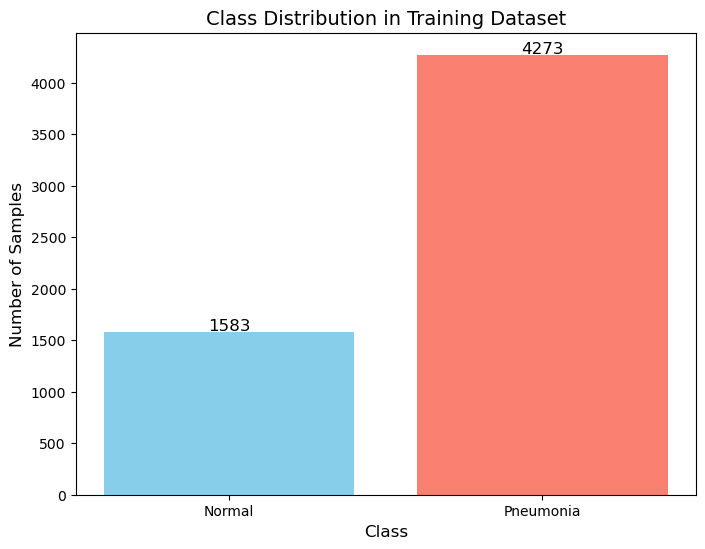

In [5]:


# Get the class distribution
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)

# Map labels to class names (0: normal, 1: pneumonia)
class_names = {0: "Normal", 1: "Pneumonia"}
counts = [class_counts[0], class_counts[1]]  # [normal_count, pneumonia_count]
labels = [class_names[0], class_names[1]]   # ["Normal", "Pneumonia"]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.title("Class Distribution in Training Dataset", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)
plt.show()

In [6]:
# Compute class weights to handle the imbalanced dataset
# Class weights are calculated as total_samples / (num_classes * class_count) to give higher weight to the minority class
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
total_samples = len(labels)
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))], dtype=torch.float)
print(f"Class weights (Normal, Pneumonia): {class_weights.tolist()}")

# Compute pos_weight for BCEWithLogitsLoss to further balance the loss function
# pos_weight is the ratio of the weight for the negative class (normal) to the positive class (pneumonia)
pos_weight = torch.tensor([class_weights[0] / class_weights[1]], dtype=torch.float)
print(f"pos_weight for BCEWithLogitsLoss: {pos_weight.item()}")

Class weights (Normal, Pneumonia): [1.8496525287628174, 0.6852328777313232]
pos_weight for BCEWithLogitsLoss: 2.6993050575256348


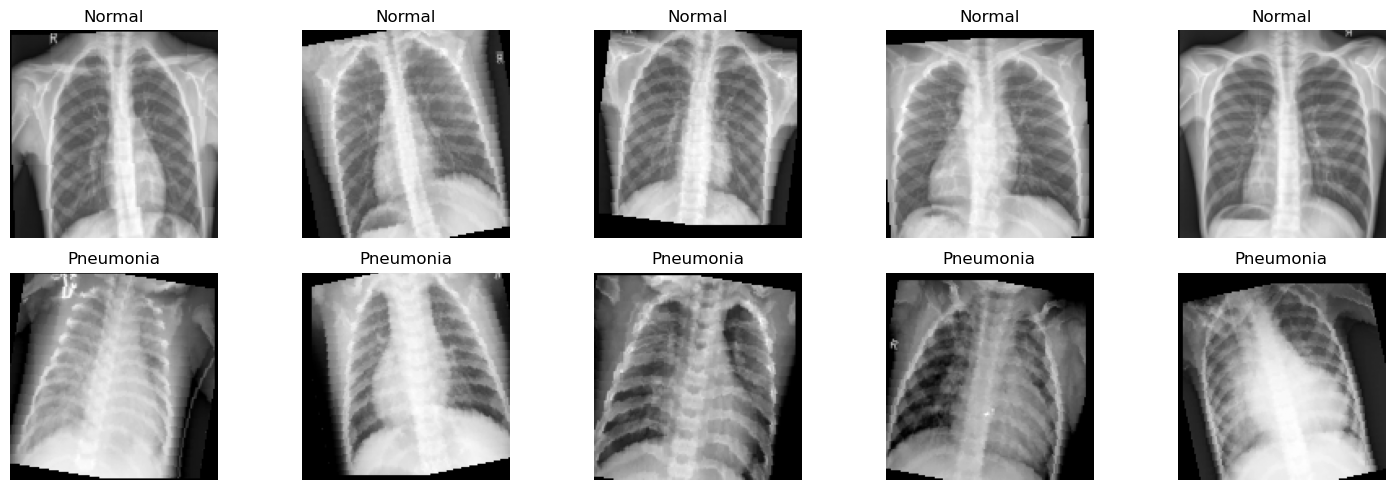

In [7]:
# -------------------------  Display Samples -------------------------
"""
This function displays sample images from the dataset to visualize the X-ray data.
It shows a few samples from both the normal and pneumonia classes to understand the visual differences between the two.
"""

def display_samples(dataset, num_samples=5):
    normal_count = 0
    pneumonia_count = 0
    class_names = dataset.classes  # ['NORMAL', 'PNEUMONIA']

    plt.figure(figsize=(15, 5))

    for i in range(len(dataset)):
        image, label = dataset[i]
        # Denormalize the image for visualization
        image = image * 0.5 + 0.5  # Reverse normalization to [0, 1]
        image = image.numpy().squeeze()  # Shape: (H, W), single channel

        if label == 0 and normal_count < num_samples:
            plt.subplot(2, num_samples, normal_count + 1)
            plt.imshow(image, cmap='gray')
            plt.title('Normal')
            plt.axis('off')
            normal_count += 1

        elif label == 1 and pneumonia_count < num_samples:
            plt.subplot(2, num_samples, num_samples + pneumonia_count + 1)
            plt.imshow(image, cmap='gray')
            plt.title('Pneumonia')
            plt.axis('off')
            pneumonia_count += 1

        if normal_count >= num_samples and pneumonia_count >= num_samples:
            break

    plt.tight_layout()
    plt.show()

display_samples(train_dataset, num_samples=5)

